In [45]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.linear_model import LinearRegression
from scipy import stats
import pylab as pl
import datetime
import math
import pydotplus 
from IPython.display import Image

# Functions for data processing & model & valuation

<li> Data preparation 

In [29]:
def data_pre(stock_file,reddit_file,nytime_file):
    
    ## Stock
    stock = pd.read_csv(stock_file)#'AMZN.csv'
    #daily
    stock['log_rt'] = np.log(stock['Adj Close']/stock['Adj Close'].shift(1))
    stock['direction'] = np.sign(stock['log_rt']) 
    # weekly
    stock['day']=stock['Date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
    stock['weekinfo'] =stock['day'].apply(lambda x: x.isocalendar())
    stock['week'] = stock['weekinfo'].apply(lambda x: str(x[0])+'-'+str(x[1]))
    stock['weekday'] = stock['weekinfo'].apply(lambda x: x[2])
    stock_weekly = pd.DataFrame(stock,columns=['week','weekday','log_rt'])
    stock_weekly=stock_weekly.groupby(by='week').mean()
    stock_weekly['direction'] = np.sign(stock_weekly['log_rt']) 
    stock_weekly = pd.DataFrame(stock,columns=['week','direction'])
    
    ## Reddit
    reddit = pd.read_csv(reddit_file)#'
    reddit = pd.DataFrame(reddit,columns=['timestamp','upvote_ratio','score','comms_num','anticipation','sadness',
                                                'joy','negative','trust','positive','surprise','disgust','anger','fear'])
    # modified
    reddit['modified_positive'] = (reddit['positive']+reddit['joy']+reddit['trust']+reddit['surprise'])/4
    reddit['modified_negative'] = (reddit['negative']+reddit['disgust']+reddit['anger']+reddit['fear'])/4
    reddit['timestamp']=reddit['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    reddit['timestamp']=reddit['timestamp'].apply(lambda x: datetime.datetime.date(x))
    # take the average of all article  post on same date
    reddit=reddit.groupby(by='timestamp').mean()
    reddit.sort_index(ascending=True,inplace=True)
    reddit=reddit.reset_index()
    reddit['Date'] = reddit['timestamp'].apply(lambda x: str(x))
    
    ## NY-times
    nytimes = pd.read_csv(nytime_file)
    nytimes = pd.DataFrame(nytimes,columns=['date','week','anticipation','sadness','joy','negative',
                                                'trust','positive','surprise','disgust','anger','fear'])
    # modified
    nytimes['modified_positive'] = (nytimes['positive']+nytimes['joy']+nytimes['trust']+nytimes['surprise'])/4
    nytimes['modified_negative'] = (nytimes['negative']+nytimes['disgust']+nytimes['anger']+nytimes['fear'])/4
    # take the average of all article  post on same date
    nytimes=nytimes.groupby(by='week').mean()
    nytimes.sort_index(ascending=True,inplace=True)
    nytimes=nytimes.reset_index()
    
    return stock, stock_weekly, reddit, nytimes

<li> Divide Train + test

In [30]:
def train_test(stock,reddit,stock_weekly,nytimes):
    from sklearn.model_selection import train_test_split
    
    ## Daily
    daily = pd.merge(stock, reddit, how='left', on='Date')
    daily=daily.dropna(how='any') 
    train, test = train_test_split(daily[1:], test_size = 0.3)  # 3:7
    x_dtrain1 = train.iloc[0:,:]
    x_dtrain1 = pd.DataFrame(x_dtrain1,columns=['upvote_ratio','score','comms_num','modified_positive','modified_negative'])
    x_dtrain2 = train.iloc[0:,14:-2]
    y_dtrain = train[['direction']]
    x_dtest1 = test.iloc[0:,:]
    x_dtest1 = pd.DataFrame(x_dtest1,columns=['upvote_ratio','score','comms_num','modified_positive','modified_negative'])
    x_dtest2 = test.iloc[0:,14:-2]
    y_dtest = test[['direction']]
    
    ## Weekly
    weekly = pd.merge(stock_weekly, nytimes, how='left', on='week')
    weekly=weekly.dropna(how='any') 
    train, test = train_test_split(weekly[1:], test_size = 0.3)  # 3:7
    x_wtrain1 = train.iloc[0:,-2:]
    x_wtrain2 = train.iloc[0:,2:-2]
    y_wtrain = train[['direction']]
    x_wtest1 = test.iloc[0:,-2:]
    x_wtest2 = test.iloc[0:,2:-2]
    y_wtest = test[['direction']]

    return x_dtrain1,x_dtrain2,y_dtrain,x_dtest1,x_dtest2,y_dtest,x_wtrain1,x_wtrain2,y_wtrain,x_wtest1,x_wtest2,y_wtest

<li> Machine Learning models (#=7)
    
    1. linear regression model
    2. Decision tree: Classification trees
    3. Random forest
    4. SVM
       (1) linear SVM
       (2) non-linear SVM: sigmoid
    5. Neural Network
       (1) linear NN: 1 layer
       (2) non-linear NN: 2-3 layers

In [31]:
def get_classification(predictions,threshold):
    classes = np.ones_like(predictions)
    for i in range(len(classes)):
        if predictions[i] < threshold:
            classes[i] = -1
    return classes

from sklearn.metrics import confusion_matrix
def c_m_analysis(true,pred,threshold):
    tn, fp, fn, tp = confusion_matrix(true,get_classification(pred,threshold)).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f_score = 2*precision*recall/(precision+recall)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    return precision,recall,fpr,f_score,accuracy

In [100]:
def ml_modle(x_train,y_train,x_test,y_test,tree_max_depth=3,threshold=0,SVM_C=1,net_pass=10,hid_layer=5):
    ## linear regression model
    from sklearn import linear_model
    model1 = linear_model.LinearRegression()
    model1.fit(x_train,y_train)
    testing_predictions1  = model1.predict(x_test)
    testing_predictions1
    linear = c_m_analysis(y_test,testing_predictions1,threshold)
    
    ## Decision tree: Classification trees
    from sklearn.tree import DecisionTreeClassifier
    from sklearn import tree
    model2 = tree.DecisionTreeClassifier(max_depth = tree_max_depth,criterion='entropy')
    model2.fit(x_train,y_train)
    testing_predictions2  = model2.predict(x_test)
    decision_tree=c_m_analysis(y_test,testing_predictions2,threshold) 
    # show graph
    import pydotplus 
    from IPython.display import Image
    feature_names = [key for key in x_train if not key == 'direction']
    dot_data = tree.export_graphviz(model2, out_file=None,feature_names=feature_names) 
    dt_graph = pydotplus.graphviz.graph_from_dot_data(dot_data)
    
    ## random forest
    from sklearn.ensemble import RandomForestClassifier
    model3 = RandomForestClassifier(n_estimators=10)
    model3.fit(x_train,y_train['direction'])
    testing_predictions3  = model3.predict(x_test)
    random_forest = c_m_analysis(y_test,testing_predictions3,threshold)
    # feature importance
    importances = model3.feature_importances_
    
    ## SVM
    # linear
    from sklearn import svm
    model4 = svm.SVC(kernel='linear', C=SVM_C) 
    model4.fit(x_train,y_train['direction'])
    model4.score(x_train,y_train)
    testing_predictions4  = model4.predict(x_test)
    SVM_linear = c_m_analysis(y_test,testing_predictions4,threshold)
    #sigmoid
    model5 = svm.SVC(kernel='sigmoid', C=SVM_C,gamma='scale') 
    model5.fit(x_train,y_train['direction'])
    model5.score(x_train,y_train)
    testing_predictions5  = model5.predict(x_test)
    SVM_sigmoid = c_m_analysis(y_test,testing_predictions5,threshold)
    
    ## Neural Network
    def sigmoid(x,deriv=False):
        if deriv:
            return sigmoid(x)*(1-sigmoid(x))
        return 1/(1+np.exp(-x))
    # one_layer for linear case
    def net_lin(X,y,activation_function=sigmoid,passes=net_pass):
        np.random.seed(1)
        syn00 = 2*np.random.random((X.shape[1],1)) - 1    # weights
        for i in range(0,passes): 
            level_00 = X
            level_10 = activation_function(np.dot(level_00,syn00))  
            level_10_error = y - level_10 #error  
            level_10_delta = level_10_error * activation_function(level_10,True)   
            syn00 += np.dot(level_00.T,level_10_delta)  # how much I need to change the weights
        return syn00
    final_weights = net_lin(x_train,y_train,sigmoid,net_pass)
    level=sigmoid(np.dot(x_test,final_weights))
    net_lin = c_m_analysis(y_test,level,np.mean(level))
    
    #multiple layers for non-linear case
    def net_non_lin(X,y,activation_function=sigmoid,hidden_layer=1,passes=10):
        import time
        np.random.seed(1)
        syn0 = 2*np.random.random((X.shape[1],hidden_layer)) - 1
        syn1 = 2*np.random.random((hidden_layer,1)) - 1
        for i in range(passes):
            level_0 = X
            level_1 = activation_function(np.dot(level_0,syn0))
            level_2 = activation_function(np.dot(level_1,syn1))

            level_2_error = y - level_2  # error term 
        # 
            level_2_delta = level_2_error*activation_function(level_2,deriv=True)

            level_1_error = level_2_delta.dot(syn1.T)

            level_1_delta = level_1_error * activation_function(level_1,deriv=True)

            syn1 += level_1.T.dot(level_2_delta)
            syn0 += level_0.T.dot(level_1_delta)
   
        return syn0,syn1
    syn0,syn1 = net_non_lin(x_train,y_train,activation_function=sigmoid,hidden_layer=hid_layer,passes=net_pass)
    level_0 = x_test
    level_1 = sigmoid(np.dot(level_0,syn0))
    level_2 = sigmoid(np.dot(level_1,syn1))
    get_classification(level_2,threshold=0.1)
    net_non_lin=c_m_analysis(y_test,level_2,np.mean(level_2))
    
    
    return linear,decision_tree,random_forest,SVM_linear,SVM_sigmoid,net_lin,net_non_lin,importances,dt_graph




<li> Valuation indicators

In [61]:
def score(models):
    model_names = ['Lnear Regerssion','Decision Tree','Random Forest','Linear SVM','Non-linear SVM(sigmoid)','Linear Neural Networks','Non-Linear Neural Networks']
    score={'Precision':[],'True Negative Rate':[],'False_Positive_Rate':[],'f_score':[],'Accuracy':[]} 
    for i in range(7):
        score['Precision'].append(models[i][0])
        score['True Negative Rate'].append(models[i][1])
        score['False_Positive_Rate'].append(models[i][2])
        score['f_score'].append(models[i][3])
        score['Accuracy'].append(models[i][4])
    score = pd.DataFrame(score,index=model_names)
    return score


# Amazon

In [121]:
stock,stock_weekly,reddit,nytimes = data_pre('AMZN.csv','am_reddit_emotions.csv','am_article_emotions.csv')
x_dtrain1,x_dtrain2,y_dtrain,x_dtest1,x_dtest2,y_dtest,x_wtrain1,x_wtrain2,y_wtrain,x_wtest1,x_wtest2,y_wtest=train_test(stock,reddit,stock_weekly,nytimes)


<li> Reddit (upvote+com_num+score+modified) 

In [122]:
daily_reddit_mod=ml_modle(x_dtrain1,y_dtrain,x_dtest1,y_dtest,tree_max_depth=3,threshold=0,SVM_C=1,net_pass=10,hid_layer=2)
score(daily_reddit_mod)

,Precision,True Negative Rate,False_Positive_Rate,f_score,Accuracy
Lnear Regerssion,0.426230,0.764706,0.875,0.547368,0.418919
Decision Tree,0.409091,0.264706,0.325,0.321429,0.486486
Random Forest,0.473684,0.529412,0.500,0.500000,0.513514
Linear SVM,0.450704,0.941176,0.975,0.609524,0.445946
Non-linear SVM(sigmoid),0.458333,0.970588,0.975,0.622642,0.459459
Linear Neural Networks,1.000000,0.088235,0.000,0.162162,0.581081
Non-Linear Neural Networks,0.555556,0.147059,0.100,0.232558,0.554054


In [74]:
#Image(daily_reddit_mod[8].create_png())

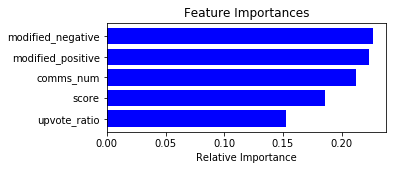

In [102]:
importances=daily_reddit_mod[7]
indices = np.argsort(importances)
plt.figure(figsize=(5,2))
feature_names = [key for key in x_dtrain1 if not key == 'direction']
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),feature_names)
plt.xlabel('Relative Importance')
plt.show()

 <li> Reddit (upvote+com_num+score+all emotions) 

In [123]:
daily_reddit_all=ml_modle(x_dtrain2,y_dtrain,x_dtest2,y_dtest,tree_max_depth=3,threshold=0,SVM_C=1,net_pass=10,hid_layer=3)
score(daily_reddit_all)

,Precision,True Negative Rate,False_Positive_Rate,f_score,Accuracy
Lnear Regerssion,0.450980,0.676471,0.700,0.541176,0.472973
Decision Tree,0.391304,0.264706,0.350,0.315789,0.472973
Random Forest,0.434783,0.588235,0.650,0.500000,0.459459
Linear SVM,0.450704,0.941176,0.975,0.609524,0.445946
Non-linear SVM(sigmoid),0.420000,0.617647,0.725,0.500000,0.432432
Linear Neural Networks,1.000000,0.088235,0.000,0.162162,0.581081
Non-Linear Neural Networks,0.459459,1.000000,1.000,0.629630,0.459459


In [75]:
#Image(daily_reddit_all[8].create_png())

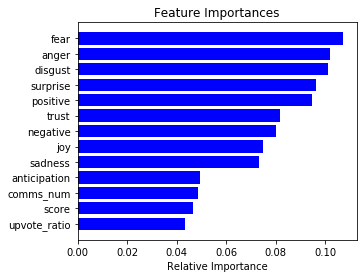

In [97]:
importances=daily_reddit_all[7]
indices = np.argsort(importances)
plt.figure(figsize=(5,4))
feature_names = [key for key in x_dtrain2 if not key == 'direction']
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),feature_names)
plt.xlabel('Relative Importance')
plt.show()

 <li> NYtimes (modified) 

In [124]:
weekly_nyt_mod=ml_modle(x_wtrain1,y_wtrain,x_wtest1,y_wtest,tree_max_depth=3,threshold=0,SVM_C=1,net_pass=10,hid_layer=1)
score(weekly_nyt_mod)

,Precision,True Negative Rate,False_Positive_Rate,f_score,Accuracy
Lnear Regerssion,0.478261,1.000000,1.000000,0.647059,0.478261
Decision Tree,0.444444,0.727273,0.833333,0.551724,0.434783
Random Forest,0.451613,0.636364,0.708333,0.528302,0.456522
Linear SVM,0.478261,1.000000,1.000000,0.647059,0.478261
Non-linear SVM(sigmoid),0.517241,0.681818,0.583333,0.588235,0.543478
Linear Neural Networks,0.333333,0.318182,0.583333,0.325581,0.369565
Non-Linear Neural Networks,0.583333,0.636364,0.416667,0.608696,0.608696


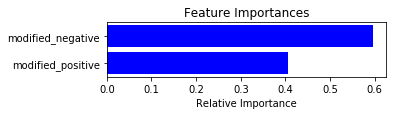

In [78]:
importances=weekly_nyt_mod[7]
indices = np.argsort(importances)
plt.figure(figsize=(5,1))
feature_names = [key for key in x_wtrain1 if not key == 'direction']
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),feature_names)
plt.xlabel('Relative Importance')
plt.show()

 <li> NYtimes (all emotions) 

In [125]:
weekly_nyt_all=ml_modle(x_wtrain2,y_wtrain,x_wtest2,y_wtest,tree_max_depth=3,threshold=0,SVM_C=1,net_pass=10,hid_layer=3)
score(weekly_nyt_all)

,Precision,True Negative Rate,False_Positive_Rate,f_score,Accuracy
Lnear Regerssion,0.470588,0.727273,0.750000,0.571429,0.478261
Decision Tree,0.500000,1.000000,0.916667,0.666667,0.521739
Random Forest,0.483871,0.681818,0.666667,0.566038,0.500000
Linear SVM,0.478261,1.000000,1.000000,0.647059,0.478261
Non-linear SVM(sigmoid),0.515152,0.772727,0.666667,0.618182,0.543478
Linear Neural Networks,0.368421,0.318182,0.500000,0.341463,0.413043
Non-Linear Neural Networks,0.681818,0.681818,0.291667,0.681818,0.695652
